https://www.kaggle.com/c/predict-west-nile-virus/data

In [1]:
# Read in the data 

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import cPickle
import math
import os

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# plot styles
plt.style.use('seaborn-whitegrid')
sns.set_style('whitegrid')

In [3]:
%ls ../assets/

noaa_weather_qclcd_documentation.pdf  train.csv
spray.csv                             weather.csv
test.csv                              west_nile.zip


In [4]:
spray = pd.read_csv('../assets/spray.csv')
weather = pd.read_csv('../assets/weather.csv')
train = pd.read_csv('../assets/train.csv')

In [5]:
print spray.shape,weather.shape,train.shape

(14835, 4) (2944, 22) (10506, 12)


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 12 columns):
Date                      10506 non-null object
Address                   10506 non-null object
Species                   10506 non-null object
Block                     10506 non-null int64
Street                    10506 non-null object
Trap                      10506 non-null object
AddressNumberAndStreet    10506 non-null object
Latitude                  10506 non-null float64
Longitude                 10506 non-null float64
AddressAccuracy           10506 non-null int64
NumMosquitos              10506 non-null int64
WnvPresent                10506 non-null int64
dtypes: float64(2), int64(4), object(6)
memory usage: 985.0+ KB


In [7]:
train.head(2)

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1,0


In [8]:
spray.head(5)

,Date,Time,Latitude,Longitude
0,2011-08-29,6:56:58 PM,42.391623,-88.089163
1,2011-08-29,6:57:08 PM,42.391348,-88.089163
2,2011-08-29,6:57:18 PM,42.391022,-88.089157
3,2011-08-29,6:57:28 PM,42.390637,-88.089158
4,2011-08-29,6:57:38 PM,42.390410,-88.088858


In [9]:
weather.head(2)

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,...,,M,M,M,0.00,29.18,29.82,2.7,25,9.6


In [10]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Block,10506.0,35.687797,24.339468,10.000000,12.000000,33.000000,52.000000,98.000000
Latitude,10506.0,41.841139,0.112742,41.644612,41.732984,41.846283,41.954690,42.017430
Longitude,10506.0,-87.699908,0.096514,-87.930995,-87.760070,-87.694991,-87.627796,-87.531635
AddressAccuracy,10506.0,7.819532,1.452921,3.000000,8.000000,8.000000,9.000000,9.000000
NumMosquitos,10506.0,12.853512,16.133816,1.000000,2.000000,5.000000,17.000000,50.000000
WnvPresent,10506.0,0.052446,0.222936,0.000000,0.000000,0.000000,0.000000,1.000000


In [11]:
spray.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14835 entries, 0 to 14834
Data columns (total 4 columns):
Date         14835 non-null object
Time         14251 non-null object
Latitude     14835 non-null float64
Longitude    14835 non-null float64
dtypes: float64(2), object(2)
memory usage: 463.7+ KB


In [12]:
spray.describe().T

,count,mean,std,min,25%,50%,75%,max
Latitude,14835.0,41.904828,0.104381,41.713925,41.785001,41.940075,41.980978,42.395983
Longitude,14835.0,-87.736690,0.067292,-88.096468,-87.794225,-87.727853,-87.694108,-87.586727


- in order to combine the spray information, will use lat/long
- only need to look at the train info for years 2011 and 2013
- look for distance between train trap site and spray
- make some reasonable cutoffs...

In [13]:
# convert Date to date_time format
# train.date = pd.to_datetime(train.Date,format='%Y-%M-%d')
# spray.date = pd.to_datetime(spray.Date,format='%Y-%M-%d')
# train.date[0]

In [14]:
spray[spray.Date == '2011-08-29'].head()

,Date,Time,Latitude,Longitude
0,2011-08-29,6:56:58 PM,42.391623,-88.089163
1,2011-08-29,6:57:08 PM,42.391348,-88.089163
2,2011-08-29,6:57:18 PM,42.391022,-88.089157
3,2011-08-29,6:57:28 PM,42.390637,-88.089158
4,2011-08-29,6:57:38 PM,42.390410,-88.088858


In [15]:
from geopy.distance import vincenty

# calculate the distance between a test trap and a spray for a given date
#test = train[9100:9110]

def calc_dist_to_spray(df):
    # list of distances
    distances_to_spray= []
    # if no spray, distance is None
    dist_to_spray = None
    
    # only need to look at 2011 and 2013
    if ('2011' in df.Date) or ('2013' in df.Date):
                
        # get the location of the trap site
        lat_long_train = (df.Latitude,df.Longitude)
        date = df.Date
        distances = []
        # look for the date in the spray info
        for ispr,spr in spray[spray.Date == date].iterrows():
            # get the location of the spray site
            lat_long_spray = (spr.Latitude,spr.Longitude)
            
            # calculate the distance between the spray and trap locations 
            distance = vincenty(lat_long_train,lat_long_spray).miles
            distances_to_spray.append(distance)
            
        # if there are distances, return the smallest one
        if len(distances_to_spray) > 0:
            # sort so the smallest distance is first
            distances_to_spray = sorted(distances_to_spray)
            
            dist_to_spray = distances_to_spray[0]
            #print dist_to_spray
            
    # return the distance (or None)
    return dist_to_spray        
            


In [16]:
# run calc_dist_to_spray over the entire data set

train['dist_to_spray'] = train.apply(calc_dist_to_spray,axis=1)

In [17]:
train.dist_to_spray.min(),train.dist_to_spray.max()

(0.0020095467526144977, 21.401390656968875)

In [20]:
train.dist_to_spray.describe()

count    801.000000
mean       6.613811
std        4.741000
min        0.002010
25%             NaN
50%             NaN
75%             NaN
max       21.401391
Name: dist_to_spray, dtype: float64

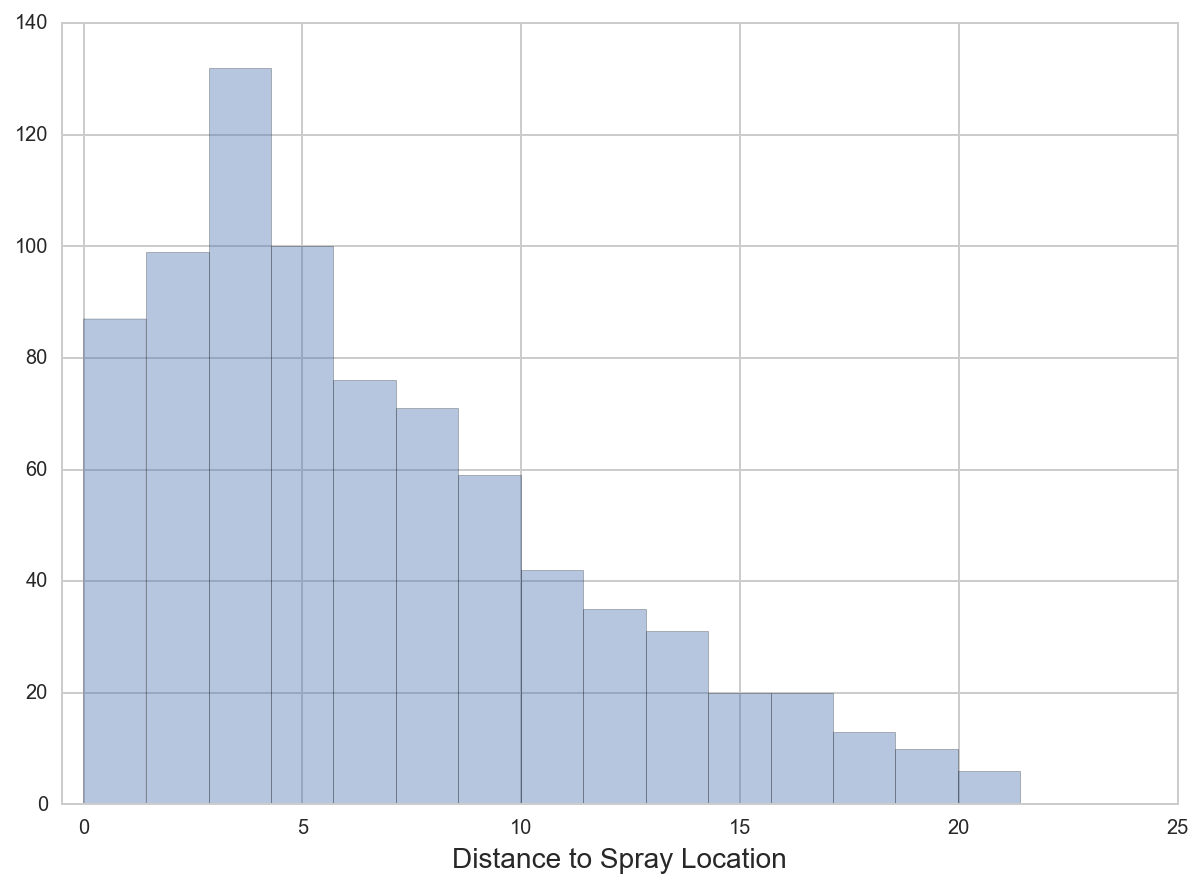

In [29]:
# look at the distribution for distances
# need to drop NaN in order for the plot to work

fig = plt.figure(figsize=(10,7))
ax = fig.gca()
sns.distplot(train.dist_to_spray.dropna(inplace=False),kde=False)
plt.xlabel('Distance to Spray Location',fontsize=14)
plt.xlim(-0.5,25)
plt.show()

In [19]:
# save the updated file

train.to_csv('../clean_data/train_with_spray.csv')